Our gj 1132 lyman alpha is fainter than https://iopscience.iop.org/article/10.3847/1538-3881/ab24c2/meta. Why?

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from astropy.time import Time
from datetime import date


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


(1212, 1218)

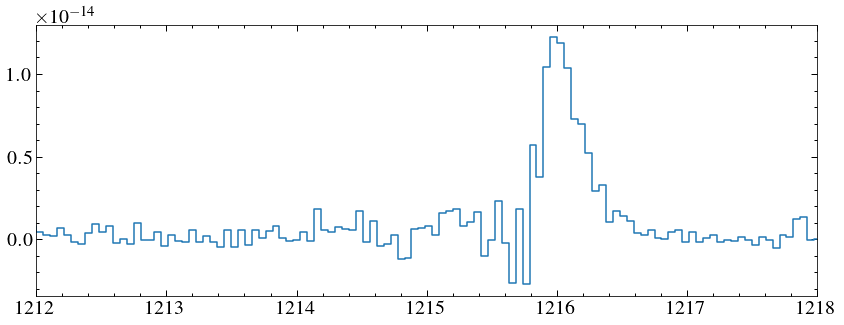

In [30]:
mmdt = Table.read('GJ1132_g140m_coadd_v1.ecsv')
plt.step(mmdt['WAVELENGTH'], mmdt['FLUX'], where='mid')
plt.xlim(1212, 1218)

Yup, they peak at ~4

In [31]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

LHS-281 oda002010


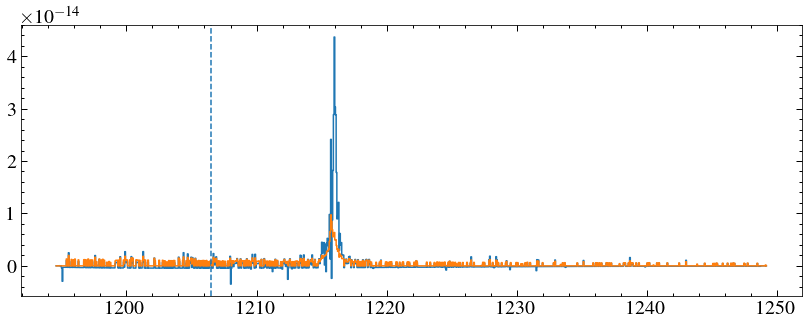

LHS-281 oda001010


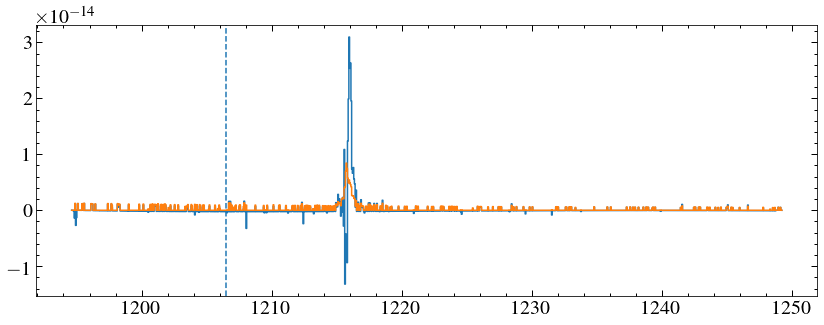

LHS-281 oda001040


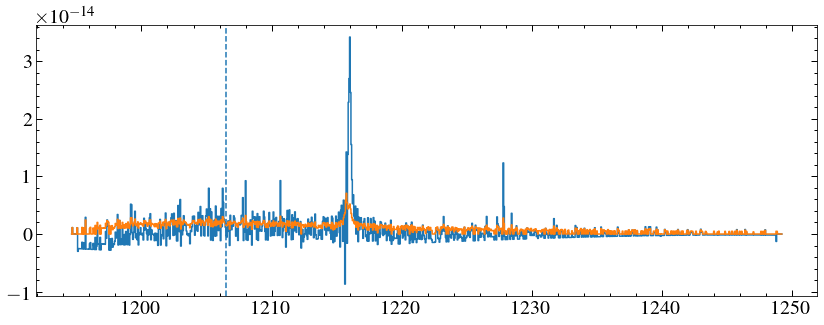

LHS-281 oda003030


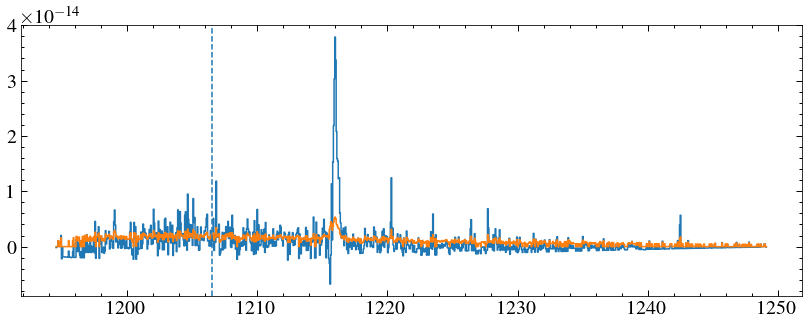

GJ1132 odlm03050


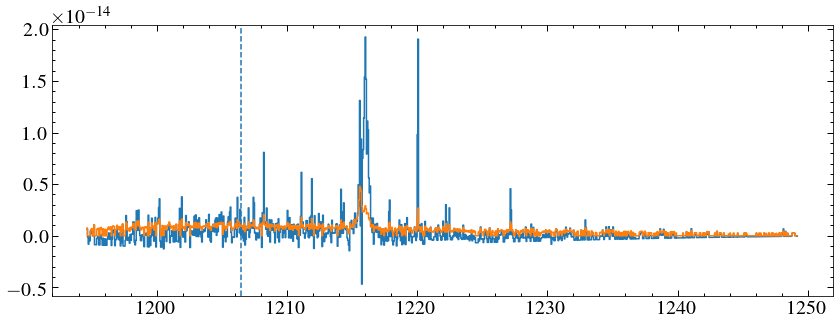

LHS-281 oda003010


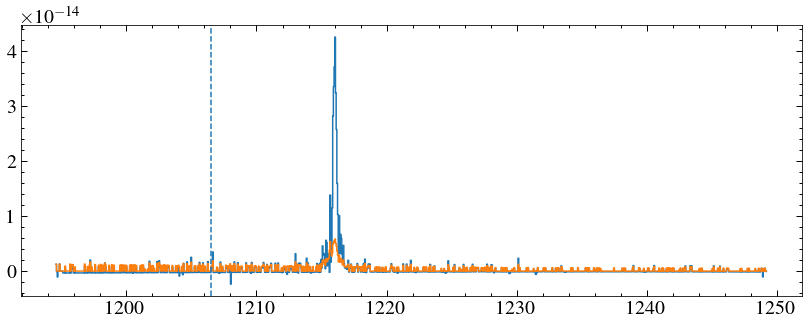

LHS-281 od2r02010


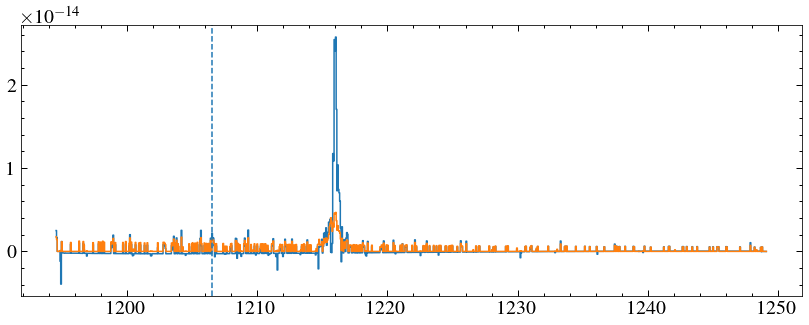

LHS-281 od2r01010


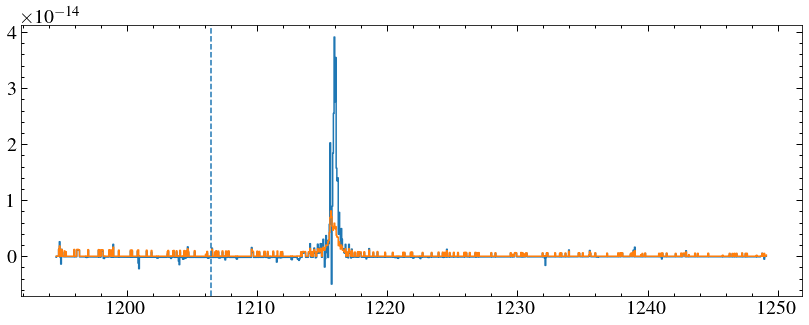

LHS-281 oda002020


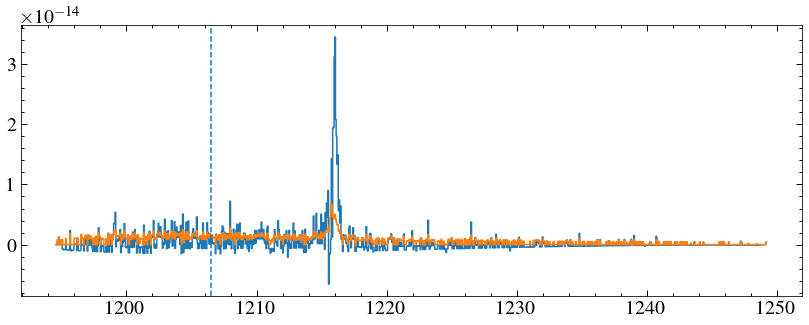

LHS-281 oda004010


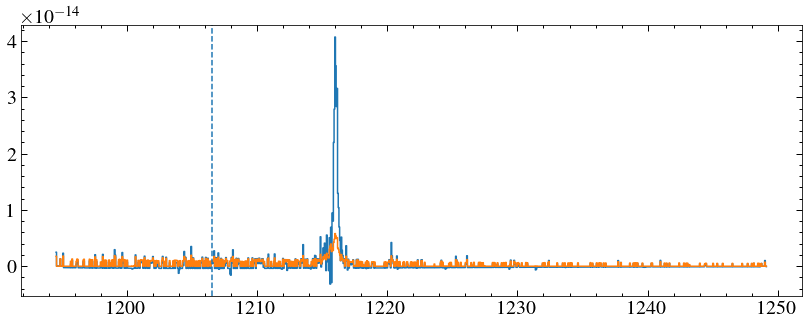

LHS-281 oda003040


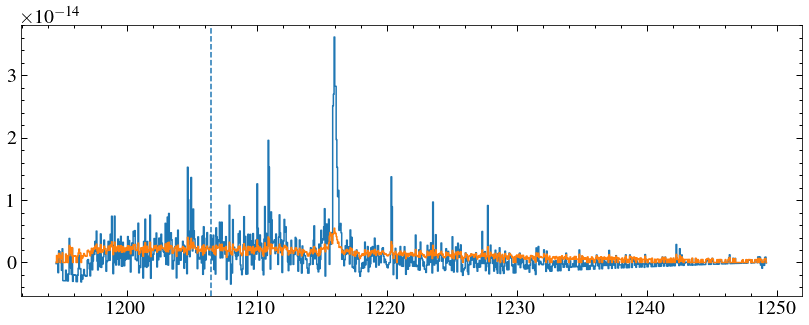

LHS-281 oda004020


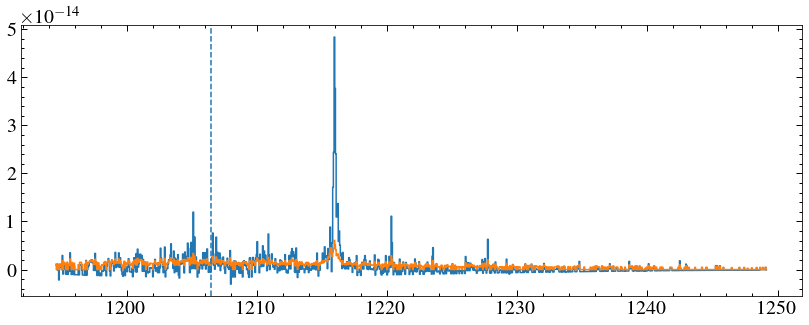

GJ1132 odlm03040


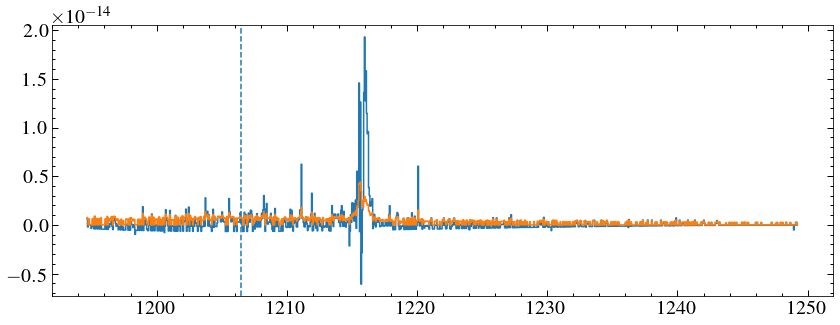

LHS-281 oda001030


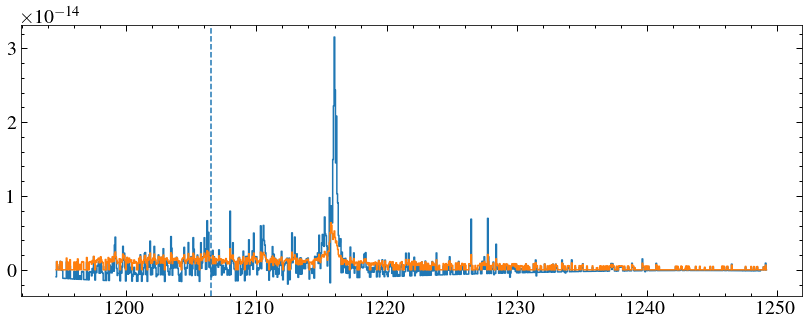

LHS-281 oda003050


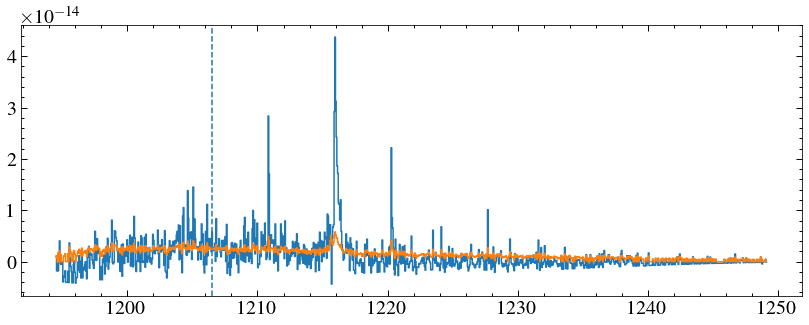

LHS-281 oda003020


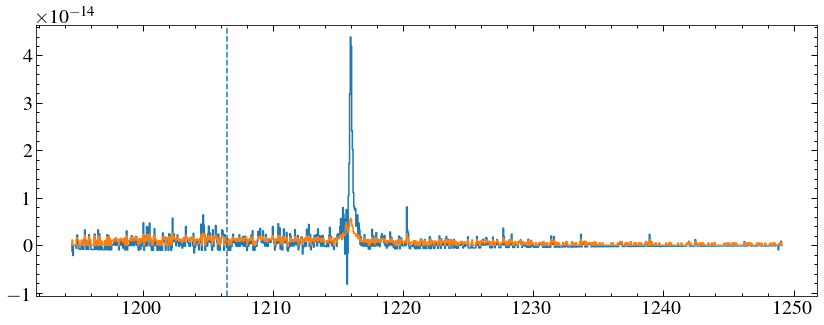

LHS-281 oda001020


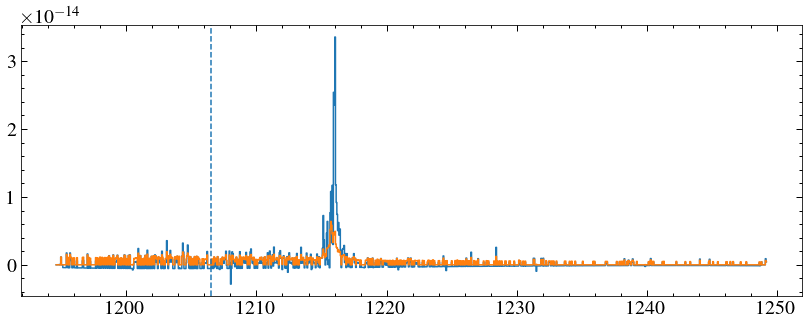

LHS-281 oda001050


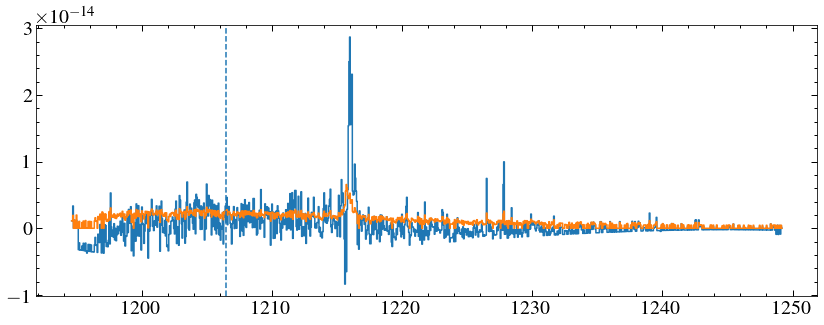

In [32]:
centab = Table.read('gj1132_trace_centers.ecsv')
rdstars = ['GJ1132', 'GJ163', 'L-980-5']
outpath = 'gj1132_extra_extractions/'
flts = glob.glob('gj1132_extra/*flt.fits')
#o_roots = ['od3v02010', 'od3v03010', 'od3v01020', 'od3v01010']
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

for flt in flts: 
    hdr = fits.getheader(flt, 0)
    target = hdr['TARGNAME']
   # if target in rdstars:
    rootname = hdr['ROOTNAME']
    SPTRCTAB = hdr['SPTRCTAB']
    grating = hdr['OPT_ELEM']
    cenwave = hdr['CENWAVE']
    tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
    rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
    x = centab['XCOL'][rootarg]
    y = centab['A2CENTER'][rootarg]
    a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
    stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, 
                      trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=0)
    x = outpath+rootname+'_new_x1d.fits'
    data = fits.getdata(x, 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    plt.axvline(1206.5, ls='--')
    #plt.xlim(1210, 1220)
    print(target, rootname)
    plt.show()
     

In [33]:
x1ds = glob.glob(outpath+'*x1d.fits')
times = []
for x in x1ds:
    times.append(fits.getheader(x)['TEXPSTRT'])
times = np.array(times)
x1ds = np.array(x1ds)
args = np.argsort(times)
times, x1ds = times[args], x1ds[args]

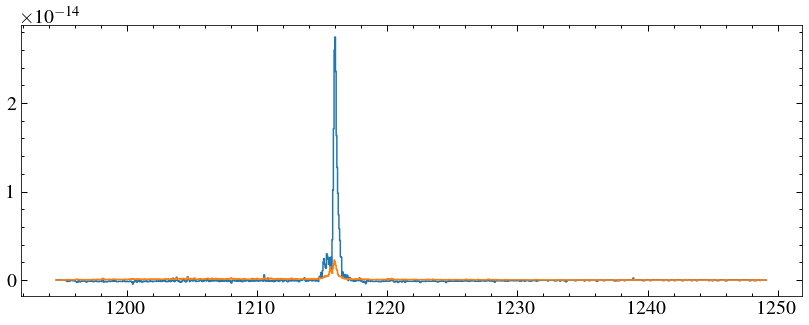

In [34]:
fs = []
es = []
first = True
for x in x1ds:
    hdul = fits.open(x)
    target = hdul[0].header['TARGNAME']
    rootname = hdul[0].header['ROOTNAME']
   
    data = hdul[1].data[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ei = no_zero_errors(fi, ei) 
    if  first:
        w_new = wi
        first = False
    else:
        fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(w_new)
        ei = interpolate.interp1d(wi, ei, fill_value='extrapolate')(w_new)
    fs.append(fi)
    es.append(ei)
    hdul.close()
f_new, e_new = new_coadd(np.array(fs), np.array(es))
plt.step(w_new, f_new, where='mid')
plt.step(w_new, e_new, where='mid')
#print(star)
#plt.show()
#savdat = Table((w_new*u.AA, f_new*u.erg/u.s/u.cm**2/u.AA, e_new*u.erg/u.s/u.cm**2/u.AA), names=['WAVELENGTH', 'FLUX', 'ERROR'])
#ascii.write(savdat, opath+star+'_g140m_coadd_v1.ecsv', overwrite=True, format='ecsv')

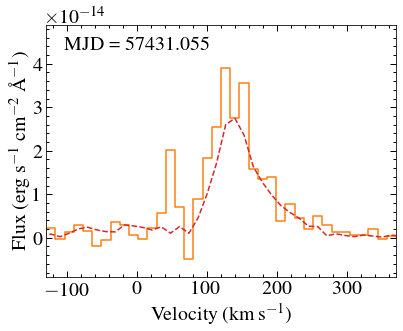

In [35]:
from matplotlib.animation import FuncAnimation




fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
fig.set_tight_layout(True)

ax.set_ylim(-0.9e-14, 4.9e-14)
ax.set_xlim(-130, 370)
#ax.set_xlim(1214.01, 1217.99)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#ax.set_xlabel('Wavelength (\AA)')
ax.set_xlabel('Velocity (km\,s$^{-1}$)')

line1, = ax.step([0,0],[0,0], where='mid', label='_')
note1 = ax.annotate('', (0.05, 0.9), xycoords ='axes fraction' )
w_dop = (w_new*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
line2 = ax.plot(w_dop, f_new, c='C3', alpha=1, ls='--')

def update(i):
    data = fits.getdata(x1ds[i], 1)[0]
    #w, f = np.array([], dtype=float), np.array([], dtype=float)
    
    wi, fi = data['WAVELENGTH'], data['FLUX']
    wi = (wi*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA))
       
    line1.set_xdata(wi)
    line1.set_ydata(fi)
    #line1.set_label(str(times[i]))
    if times[i] in [58594.37935902, 58594.44553976]:
        line1.set_color('C1')
    note1.set_text('MJD = {0:10.3f}'.format(times[i]))

    return ax, line1, note1

anim = FuncAnimation(fig, update, frames=np.arange(len(x1ds)), interval=300)
plt.tight_layout()
anim.save('gj1132_test.gif', dpi=80, writer='imagemagick')
#anim.save('djw1.gif', dpi=80, writer='imagemagick')
plt.show()

In [36]:
flux = []
error = []
for x in x1ds:
    data = fits.getdata(x,1)[0]
    w, f, e, = data['WAVELENGTH'], data['Flux'], data['ERROR']

    v = (w*u.AA).to(u.km/u.s, equivalencies= u.doppler_optical(1215.44*u.AA)).value
    mask =  (v >= 100) & (v <= 200)
    v, f, e = v[mask], f[mask], e[mask]

    fi = np.trapz(f, v)
    ei = np.sum(e[1:]**2*np.diff(v)**2)**0.5 
    flux.append(fi)
    error.append(ei)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


973.4877094614292


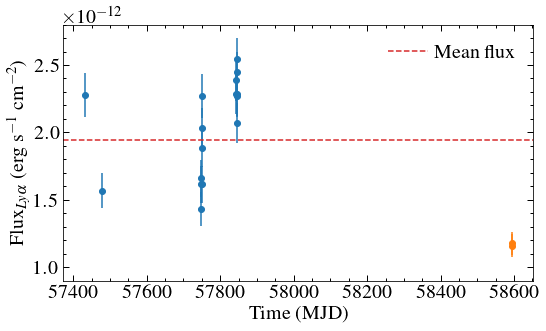

In [37]:
fitter = fitting.LevMarLSQFitter()
plt.figure(figsize=(8, 5))
plt.errorbar(times[:-2], flux[:-2], yerr=error[:-2], ls='none', marker='o')
plt.errorbar(times[-2:], flux[-2:], yerr=error[-2:], ls='none', marker='o')
plt.axhline(np.mean(flux), ls='--', c='C3', label='Mean flux')
plt.xlabel('Time (MJD)')
plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')
plt.legend()
plt.ylim(0.9e-12, 2.8e-12)
sin_mod =  models.Sine1D(amplitude=1e-12, frequency=1/1000) + models.Const1D(2e-12)
sin_fit = fitter(sin_mod, times, flux, weights = 1/np.array(error), maxiter=10000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit = np.arange(times[0]-100, times[-1]+200, 10)
#plt.plot(timefit, sin_fit(timefit))

plt.tight_layout()
#plt.savefig('gj1132_lya_flux.png')
#plt.fig('djw2.png', dpi=150)
print(1/sin_fit[0].frequency)
#print(sin_fit)

451.6980937507473
137.21991083670392
3.3638911462648076
2.227144796005343e-12
441.581931149769
7.177516626687454
2.3131553072782797e-12
524.0192981438586
17.819024562254448
1.022746640203587e-12
973.4877094614292
353.1277098889372
1.493316560911697e-12


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


8.515681403948203e-14


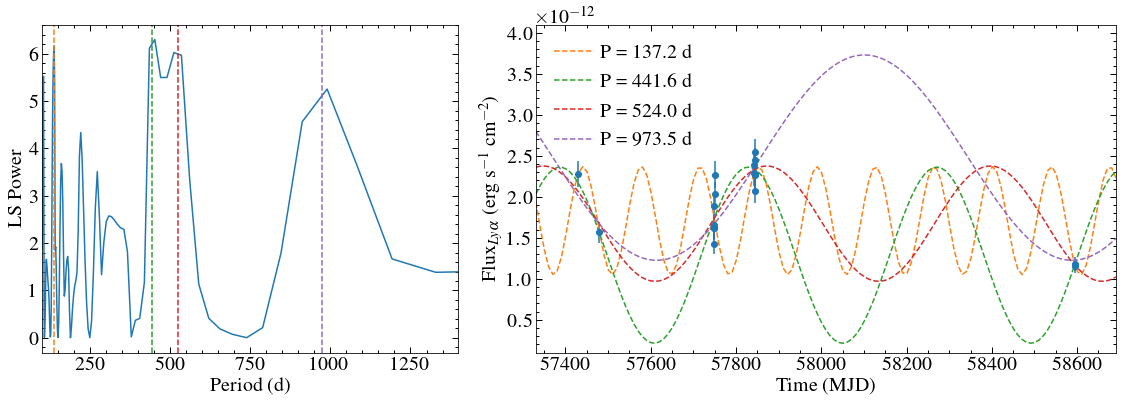

In [108]:
from astropy.timeseries import LombScargle
import matplotlib.gridspec as gridspec


plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1,7)
ls =  LombScargle(times, flux, dy=np.array(error), normalization='model')
frequency, power = ls.autopower(maximum_frequency = 1/100, minimum_frequency=1/1500, samples_per_peak=10)
plt.subplot(gs[0:3])

plt.plot(1/frequency, power)
period = 1/frequency[np.argmax(power)]
print(period)
plt.xlabel('Period (d)')
plt.ylabel('LS Power')
#plt.annotate('P\_max = {0:10.1f} d'.format(period), (0.6, 0.9), xycoords ='axes fraction' )
#plt.axhline(ls.false_alarm_level(0.01))
plt.xlim(101, 1399)


plt.subplot(gs[3:])
plt.errorbar(times, flux, yerr=error, ls='none', marker='o')

plt.xlabel('Time (MJD)')
plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')

#plt.ylim(-1e-12, 2.8e-12)
today = Time('2020-3-03', format='iso')
today = today.mjd
#print(today)
#plt.axvline(today+21, ls='-.', c='C0', label='Requested observing window ')
#plt.axvspan(today+2, today+31, color='C0', alpha=0.5)
#plt.axvspan(today+85, today+95, color='C0', alpha=0.5)
plt.axvline(today)
#plt.axvline(59000, ls = '-.', c='C0')
#plt.axvline(58950, ls = '-.', c='C0')



timefit = np.arange(times[0]-100, times[-1]+100, 10)

#f_guess = frequency[np.argmax(power)]
#f_guess = 1/550
periods = []
p_errors = []
for f_guess in (1/130, frequency[np.argmax(power)], 1/550, 1/1000):
    sin_mod =  models.Sine1D(amplitude=1e-12, frequency=f_guess) + models.Const1D(2e-12)
    sin_fit = fitter(sin_mod, times, flux, weights = 1/np.array(error), maxiter=100000)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    p_fit =  1/sin_fit[0].frequency
    periods.append(p_fit)
    p_e = sin_fit_e[1]/(sin_fit[0].frequency.value**2)
    p_errors.append(p_e)
    print(p_fit)
    print(p_e)
    label = 'P = {0:10.1f} d '.format(p_fit)
    idx = (np.abs(timefit - today)).argmin()
    print(sin_fit(timefit)[idx])
    #label = 'P = {0:10.0f} $\pm$ {1:10.0f}d '.format(p_fit, p_e)
    
    plt.plot(timefit, sin_fit(timefit), label=label, ls='--')
#plt.annotate('P\_fit = {0:10.1f} $\pm$ {1:10.1f}d '.format(p_fit, p_e), (0.5, 0.9), xycoords ='axes fraction' )
#plt.xlim(times[0]-300, today+2000)
plt.ylim(0.1e-12, 4.1e-12)
plt.xlim(timefit[0], timefit[-1])
plt.legend(loc=2)


plt.subplot(gs[0:3])
[plt.axvline(p, ls='--', c=c) for p, c in zip(periods,['C1', 'C2', 'C3', 'C4'])]

plt.tight_layout()
plt.savefig('four_periods.pdf', dpi=100)
#print(len(flux))
print(error[-1])

In [39]:
print((3.0228384746733945e-12 - 2.3568244226135025e-12) / 8.515681403948203e-14)
print((3e-12 - 2.4e-12) / 1e-13)

7.821030642963015
6.000000000000003


In [40]:
today = date.today()
today

datetime.date(2020, 3, 3)

Adding K Melbourne's Ca data


In [41]:
ca = np.loadtxt('HARPS_GJ1132_cahk_spectra.txt')

(57350, 57900)

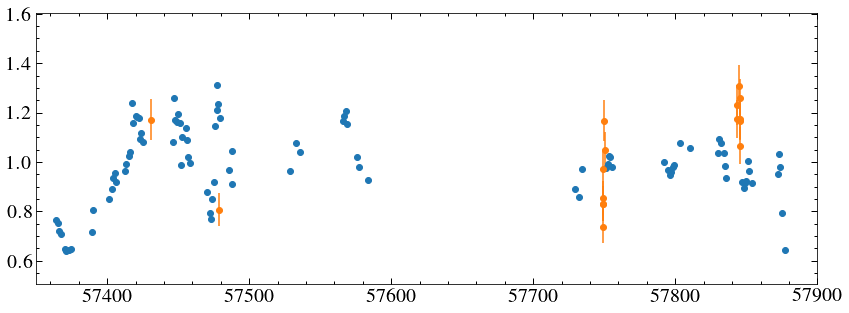

In [42]:
s, se , stime = ca[:,0], ca[:,1], ca[:,-1]
sc = convolve(s,Box1DKernel(5))
plt.errorbar(stime, sc/np.mean(sc), marker='o', ls='none')
#plt.errorbar(stime, s/np.mean(s), marker='o', ls='none')
plt.errorbar(times, flux/np.mean(flux), yerr=error/np.mean(flux), ls='none', marker='o')
#plt.ylim(0, 6)
plt.xlim(57350, 57900)
#plt.savefig('s_v_lya_rough.png')

In [43]:
#plt.plot(stime,s/se)

Looking at Si iii

In [44]:
"""siiii = [1206.51, 1206.53]
for x in x1ds:
    data = fits.getdata(x,1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(w, f, where='mid')save
    plt.step(w, e, where='mid')
    plt.xlim(1206, 1208)
    plt.ylim(-0.1e-14, 2e-14)
    [plt.axvline(line, ls='--', c='r') for line in siiii]
    plt.show()"""

"siiii = [1206.51, 1206.53]\nfor x in x1ds:\n    data = fits.getdata(x,1)[0]\n    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']\n    plt.step(w, f, where='mid')save\n    plt.step(w, e, where='mid')\n    plt.xlim(1206, 1208)\n    plt.ylim(-0.1e-14, 2e-14)\n    [plt.axvline(line, ls='--', c='r') for line in siiii]\n    plt.show()"

In [45]:
"""plt.step(w_new, f_new)
plt.xlim(1206, 1207)
plt.ylim(-0.1e-14, 2e-14)
[plt.axvline(line, ls='--', c='r') for line in siiii]"""

"plt.step(w_new, f_new)\nplt.xlim(1206, 1207)\nplt.ylim(-0.1e-14, 2e-14)\n[plt.axvline(line, ls='--', c='r') for line in siiii]"

Looking at solar lya

In [46]:
from netCDF4 import Dataset
sol = Dataset('lyman_alpha_composite.nc', 'r')
sol.variables.keys()

odict_keys(['time', 'irr_121', 'irr_121_uncertainty', 'irr_121_id', 'convert_to_photons'])

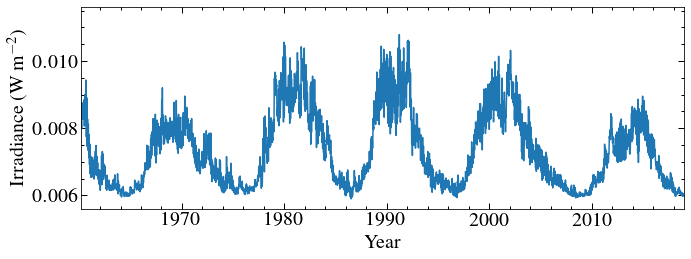

In [47]:
plt.figure(figsize=(10,4))
soltime = sol.variables['time'][:]
sollya = sol.variables['irr_121'][:]
solerror = sol.variables['irr_121_uncertainty'][:]
plt.plot(((soltime/365.25)+1947)[10:-10], convolve(sollya,Box1DKernel(10))[10:-10])
plt.xlim(1960.1, 2019)
plt.ylabel('Irradiance (W m$^{-2}$) ')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('sol_lya.pdf')
#plt.errorbar(soltime, sollya,yerr=solerror, marker='o', ls='none')

In [48]:
"""#periodicity of the solar lya
ls =  LombScargle(soltime, sollya, dy=np.array(solerror))#, normalization='model')
frequency, power = ls.autopower(maximum_frequency = 1/0.01, minimum_frequency=1/0.1, samples_per_peak=10)
#plt.subplot(gs[0:3])

plt.plot(1/frequency, power)
period = 1/frequency[np.argmax(power)]
print(period)"""

"#periodicity of the solar lya\nls =  LombScargle(soltime, sollya, dy=np.array(solerror))#, normalization='model')\nfrequency, power = ls.autopower(maximum_frequency = 1/0.01, minimum_frequency=1/0.1, samples_per_peak=10)\n#plt.subplot(gs[0:3])\n\nplt.plot(1/frequency, power)\nperiod = 1/frequency[np.argmax(power)]\nprint(period)"

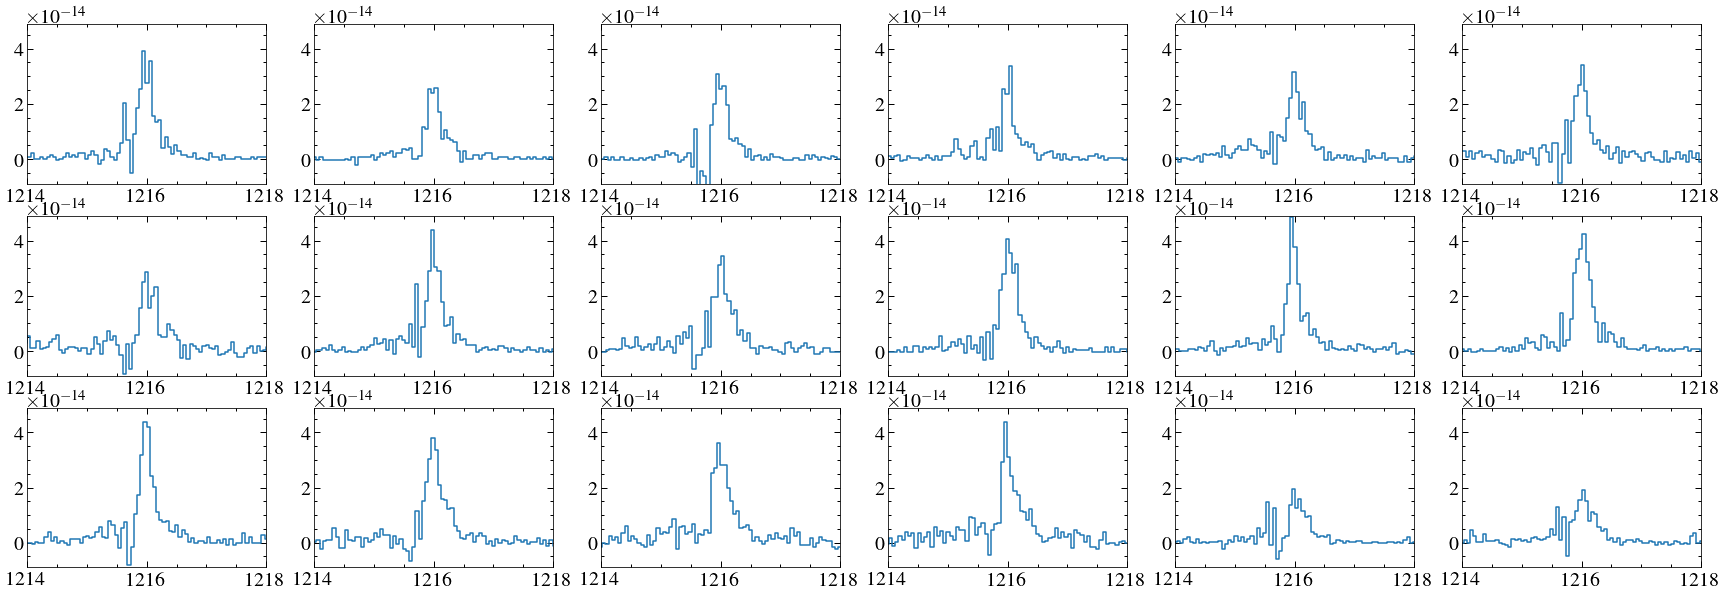

In [49]:
plt.figure(figsize=(30, 10))
for i, x in enumerate(x1ds):
    data = fits.getdata(x1ds[i], 1)[0]
    wi, fi = data['WAVELENGTH'], data['FLUX']
    plt.subplot(3,6, i+1)
    plt.step(wi, fi, where='mid')
    plt.xlim(1214, 1218)
    plt.ylim(-0.9e-14, 4.9e-14)

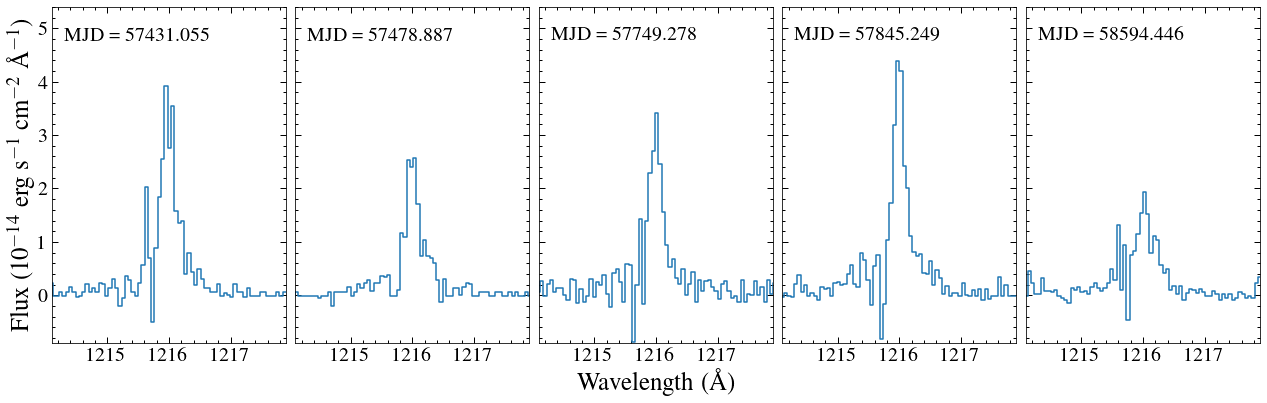

In [50]:
plt.figure(figsize=(18, 6))
eg_lines = [0, 1, 5, 12, 17]
n = 0
for i, x in enumerate(x1ds):
    if i in eg_lines:
        n +=1 
        plt.subplot(1, 5, n) 
        data = fits.getdata(x1ds[i], 1)[0]
        wi, fi = data['WAVELENGTH'], data['FLUX']
        #if n > 1:
        fi *= 1e14
        plt.step(wi, fi, where='mid')
        plt.xlim(1214.1, 1217.9)
        plt.ylim(-0.9, 5.4)
        plt.annotate('MJD = {0:10.3f}'.format(times[i]), (0.05, 0.9), xycoords ='axes fraction')
        if n > 1:
            plt.yticks(visible=False)
        if n == 1:
            plt.ylabel('Flux (10$^{-14}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25) 
        if n == 3:
            plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.04)        
plt.savefig('ly_eg_lines.pdf')        

58896.0
441.418274458948
7.100720566443128
524.0192981438586
17.819024562254448
973.4877094614292
353.1277098889372
137.21991083670392
3.3638911462648076


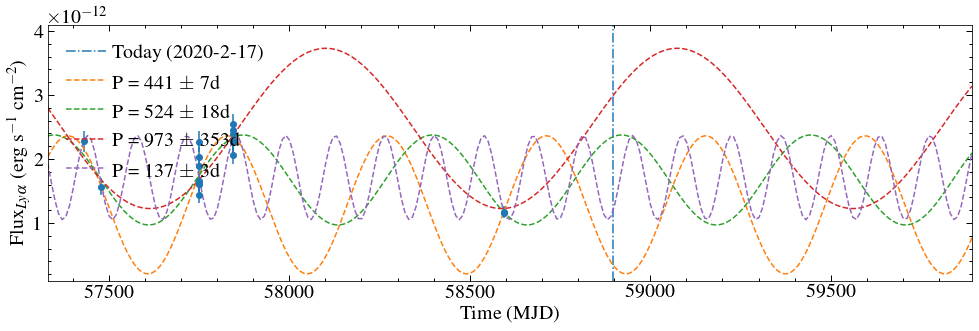

In [51]:

plt.figure(figsize=(14, 5))


plt.errorbar(times, flux, yerr=error, ls='none', marker='o')

plt.xlabel('Time (MJD)')
plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')

today = Time('2020-2-17', format='iso')
today = today.mjd
print(today)
plt.axvline(today, ls='-.', c='C0', label='Today (2020-2-17)')

timefit = np.arange(times[0]-100, today+1000, 10)

#f_guess = frequency[np.argmax(power)]
#f_guess = 1/550
periods = []
p_errors = []
for f_guess in (1/440, 1/550, 1/1000, 1/130):
    sin_mod =  models.Sine1D(amplitude=1e-12, frequency=f_guess) + models.Const1D(2e-12)
    sin_fit = fitter(sin_mod, times, flux, weights = 1/np.array(error), maxiter=100000)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    p_fit =  1/sin_fit[0].frequency
    periods.append(p_fit)
    p_e = sin_fit_e[1]/(sin_fit[0].frequency.value**2)
    p_errors.append(p_e)
    print(p_fit)
    print(p_e)
    #label = 'P\_fit = {0:10.1f} d '.format(p_fit)
    label = 'P = {0:10.0f} $\pm$ {1:10.0f}d '.format(p_fit, p_e)
    
    plt.plot(timefit, sin_fit(timefit), label=label, ls='--')
#plt.annotate('P\_fit = {0:10.1f} $\pm$ {1:10.1f}d '.format(p_fit, p_e), (0.5, 0.9), xycoords ='axes fraction' )
#plt.xlim(times[0]-300, today+2000)
plt.ylim(0.1e-12, 4.1e-12)
plt.xlim(timefit[0], timefit[-1])
plt.legend(loc=2)



plt.tight_layout()
plt.savefig('periods.pdf', dpi=100)


In [52]:
137/2

68.5

In [53]:
today+21

58917.0

New ca data

339.6825387374304


94.72995986718841
175.2019668611152
339.87784717460784


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


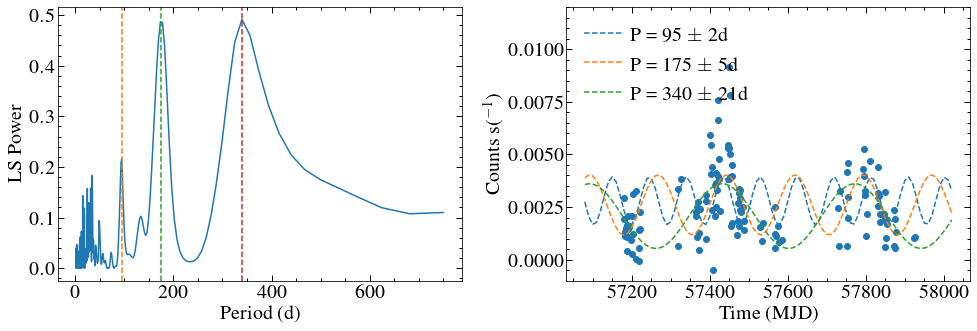

In [54]:
cat, caf = np.loadtxt('GJ1132_CaII_K_line.txt', unpack=True)
cat, caf = cat[caf < 0.05], caf[caf< 0.05]
cae = abs(caf)**0.05
args = np.argsort(cat)
cat, caf, cae = cat[args], caf[args], cae[args]


plt.subplot(121)
ls =  LombScargle(cat, caf, normalization='model')
frequency, power = ls.autopower(maximum_frequency = 1/2, minimum_frequency=1/750, samples_per_peak=10)

plt.plot(1/frequency, power)
period = 1/frequency[np.argmax(power)]
#plt.axhline(ls.false_alarm_level(0.01))
print(period)
plt.xlabel('Period (d)')
plt.ylabel('LS Power')

plt.subplot(122)
plt.scatter(cat, caf)
plt.xlabel('Time (MJD)')
plt.ylabel('Counts s($^{-1}$)')

timefit = np.arange(min(cat)-100, max(cat)+100, 10)

#f_guess = frequency[np.argmax(power)]
#f_guess = 1/550
periods = []
p_errors = []
for f_guess in (1/100,1/170, 1/339):#, 1/1000):
    sin_mod =  models.Sine1D(amplitude=0.001, frequency=f_guess) + models.Const1D(0)
  #  sin_fit = fitter(sin_mod, cat, caf, weights = 1/np.array(cae), maxiter=10000)
    sin_fit = fitter(sin_mod, cat, caf, maxiter=10000)
   # sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    p_fit =  1/sin_fit[0].frequency
    periods.append(p_fit)
    p_e = sin_fit_e[1]/(sin_fit[0].frequency.value**2)
    p_errors.append(p_e)
    print(p_fit)
   # print(p_e)
    #label = 'P\_fit = {0:10.1f} d '.format(p_fit)
    label = 'P = {0:10.0f} $\pm$ {1:10.0f}d '.format(p_fit, p_e)
    
    plt.plot(timefit, sin_fit(timefit), label=label, ls='--')
#plt.annotate('P\_fit = {0:10.1f} $\pm$ {1:10.1f}d '.format(p_fit, p_e), (0.5, 0.9), xycoords ='axes fraction' )
#plt.xlim(times[0]-300, today+2000)
#plt.ylim(0.1e-12, 4.1e-12)
#plt.xlim(timefit[0], timefit[-1])
plt.legend(loc=2)
plt.ylim(-0.001, 0.012)
plt.subplot(121)
[plt.axvline(p, ls='--', c=c) for p, c in zip(periods,['C1', 'C2', 'C3', 'C4'])]
plt.tight_layout()
plt.savefig('ca_periods.png')

In [55]:
cat[-1]

57925.03295834

In [60]:
#hdr

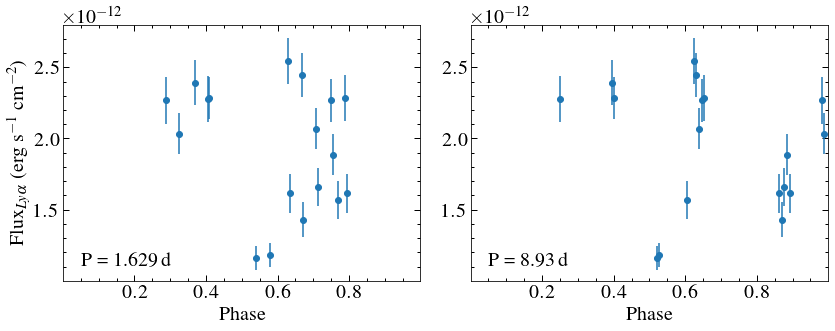

In [76]:
#planets
planet_periods = [1.629, 8.93]  
plt.figure(figsize=(12, 5))
for i, p in enumerate(planet_periods):
    tfold = times/p %1
    plt.subplot(1, 2, i+1)
    plt.errorbar(tfold, flux, yerr=error, ls='none', marker='o')
    plt.xlabel('Phase')
    if i == 0:
        plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')
    plt.annotate('P = {}\,d'.format(p), (0.05, 1.1e-12), xycoords = 'data')
    plt.xlim(0.001, 0.999)
    plt.ylim(1.001e-12, 2.8e-12)

plt.tight_layout()
plt.savefig('planets.pdf')

In [85]:
import lightkurve as lk
from astropy.units import cds
cds.enable()

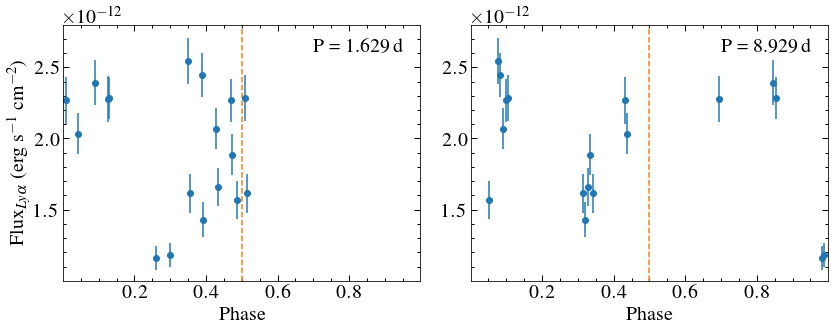

In [113]:
lc = lk.LightCurve(time= times, flux = flux, flux_err = error)

planet_periods = [1.629, 8.929]  
ephs = [7184.55786+2450000-2400000.5 , 7506.02+24500000-2400000.5 ]
plt.figure(figsize=(12, 5))
for i, p in enumerate(planet_periods):
    tfold = times/p %1
    plt.subplot(1, 2, i+1)
    lcfold = lc.fold(p, t0= ephs[i])
    plt.errorbar(lcfold.time+0.5, lcfold.flux, yerr=lcfold.flux_err, ls='none', marker='o')
    plt.xlabel('Phase')
    if i == 0:
        plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')
    plt.annotate('P = {}\,d'.format(p), (0.7, 2.6e-12), xycoords = 'data')
    plt.xlim(0.001, 0.999)
    plt.ylim(1.001e-12, 2.8e-12)
    plt.axvline(0.5, ls='--', c='C1')

plt.tight_layout()
plt.savefig('planets.pdf')

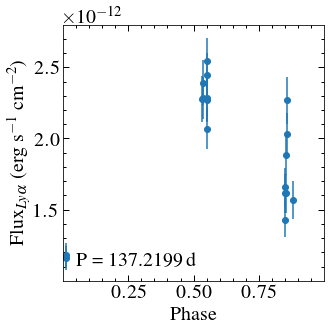

In [100]:
#planets
test_period = 137.2199  
plt.figure(figsize=(5, 5))
tfold = times/test_period %1
    
plt.errorbar(tfold, flux, yerr=error, ls='none', marker='o')
plt.xlabel('Phase')

plt.ylabel(r'Flux$_{Ly\alpha}$ (erg s$^{-1}$ cm$^{-2}$)')
plt.annotate('P = {}\,d'.format(test_period), (0.05, 1.1e-12), xycoords = 'data')
plt.xlim(0.001, 0.999)
plt.ylim(1.001e-12, 2.8e-12)

plt.tight_layout()
#plt.savefig('planets.pdf')

In [105]:
savdat = Table([times, flux, error], names=['MJD','FLUX', 'ERROR'])
ascii.write(savdat, 'gj1132_lya_lc.ecsv', format='ecsv', overwrite=True)

In [110]:
print( (100*u.km/u.s).to(u.AA, equivalencies= u.doppler_optical(1215.44*u.AA)).value)
print( (200*u.km/u.s).to(u.AA, equivalencies= u.doppler_optical(1215.44*u.AA)).value)

1215.8454271438677
1216.2508542877354


In [118]:
print(np.mean(flux))
print(np.median(flux))
print(np.std(flux))
print(np.min(flux))
print(np.max(flux))

1.9431574641124445e-12
2.0522603164267905e-12
4.2773235638385057e-13
1.1606312436604227e-12
2.5423241488139676e-12


1.360210224878711e-12
